# Getting the Price Right: Tools for Optimal Price Setting

In [533]:
# Preliminaries
library(dplyr)
library(magrittr)
library(ggplot2)
library(tidyr)

# Multiplot, from http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [544]:
# Simulate data
set.seed(0)

T <- 90
n_per_day <- 10000
n <- T * n_per_day
day_index <- sort(rep(seq(1,T), n_per_day))

mean_utility <- 0.5
price_coefficient <- -0.5
utility_outside <- 0

high_price = 0.8
low_price = 0.4

df <- data.frame(day_index = day_index,
                 simulatedErrorProduct = rnorm(n = n)) %>%
      mutate(prices = c(rep(low_price, n / 2), rep(high_price, n / 2)),
             utility_product = mean_utility + simulatedErrorProduct + price_coefficient * prices,
             utility_outside = utility_outside,
             purchase_binary = (utility_product > utility_outside))

true_elasticity <- (
                    pnorm(mean_utility + price_coefficient * high_price) - 
                    pnorm(mean_utility + price_coefficient * low_price)
                   ) / (high_price - low_price) * mean(df$prices) / mean(df$purchase_binary)

## Comparing Three Simple Regression Models

### Model 1: Observe Purchase Binary, OLS Model

In [545]:
ols <- df %>% 
    lm(purchase_binary ~ prices,
           data = .) %>%
    summary()

ols

ols_elasticity <- ols$coefficients[2] * mean(df$prices) / mean(df$purchase_binary)


Call:
lm(formula = purchase_binary ~ prices, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6186 -0.5401  0.3814  0.4599  0.4599 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.697116   0.001640  424.99   <2e-16 ***
prices      -0.196244   0.002594  -75.67   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4921 on 899998 degrees of freedom
Multiple R-squared:  0.006321,	Adjusted R-squared:  0.00632 
F-statistic:  5725 on 1 and 899998 DF,  p-value: < 2.2e-16


### Model 2. Observe Purchase Binary, Logit Model

In [546]:
logit <- df %>%
    glm(formula = purchase_binary ~ prices,
        family = binomial(link = 'logit'),
        data = .) %>%
    summary()

logit

logit_elasticity <- logit$coefficients[2] * (1 - mean(df$purchase_binary)) * mean(df$prices)


Call:
glm(formula = purchase_binary ~ prices, family = binomial(link = "logit"), 
    data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3885  -1.2464   0.9801   1.1099   1.1099  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.806545   0.006828  118.12   <2e-16 ***
prices      -0.807149   0.010714  -75.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1224891  on 899999  degrees of freedom
Residual deviance: 1219195  on 899998  degrees of freedom
AIC: 1219199

Number of Fisher Scoring iterations: 4


### Model 3: Observe Total Quantity Purchased, OLS Model

In [547]:
df_by_day <-  df %>% 
    group_by(day_index) %>%
    summarise(quantity = sum(purchase_binary),
              prices = max(prices))

quantity_model <- df_by_day %>% 
    lm(quantity ~ prices,
       data = .) %>%
    summary()

quantity_model

quantity_elasticity <- quantity_model$coefficients[2] * mean(df_by_day$prices) / mean(df_by_day$quantity)


Call:
lm(formula = quantity ~ prices, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-114.178  -37.944    1.322   31.317  107.800 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6971.16      15.80  441.26   <2e-16 ***
prices      -1962.44      24.98  -78.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.4 on 88 degrees of freedom
Multiple R-squared:  0.9859,	Adjusted R-squared:  0.9858 
F-statistic:  6172 on 1 and 88 DF,  p-value: < 2.2e-16


### Comparing Elasticities

In [556]:
data.frame(true = true_elasticity, 
           ols_binary = ols_elasticity,
           logit_binary = logit_elasticity,
           ols_quantity = quantity_elasticity)

,true,ols_binary,logit_binary,ols_quantity
1,-0.2021603,-0.2032326,-0.2037073,-0.2032326


### Comparing Estimated Demand Curves, and the Implied Profit Functions & Optimal Prices

,prices,model,quantities,profit
1,1.78,ols,313020.4,557176.3
2,1.86,logit,299679,557402.9


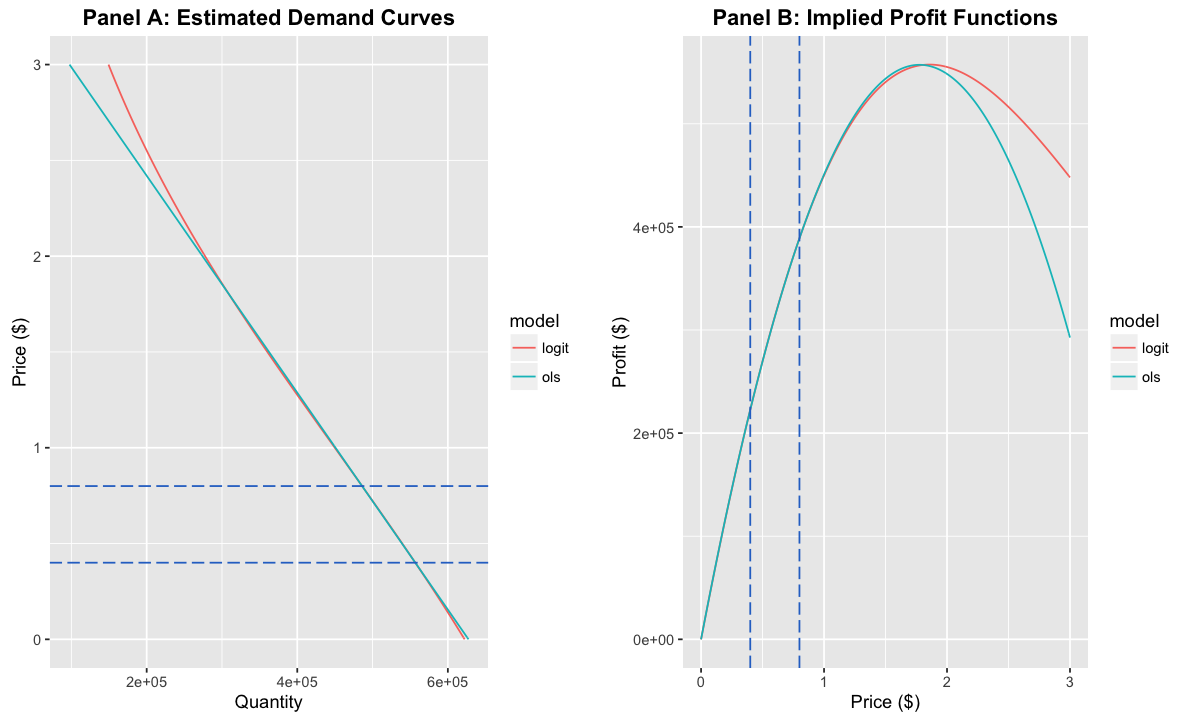

In [558]:
demand_curves <- data.frame(prices = seq(from = 0, to = 3, by = 0.01))

demand_curves %<>%
    mutate(ols = n *
            (ols$coefficients[1] + ols$coefficients[2] * prices),
           logit = n *
            (exp(logit$coefficients[1] + logit$coefficients[2] * prices) / 
             (1 + exp(logit$coefficients[1] + logit$coefficients[2] * prices)))) %>%
    gather(model, quantities, -prices)


demand_plot <- ggplot(data = demand_curves, aes(x = quantities, y = prices, color = model)) + 
    geom_line() + 
    labs(x = 'Quantity', y = 'Price ($)', title = 'Panel A: Estimated Demand Curves') + 
    geom_hline(yintercept = c(low_price, high_price), colour = "#2A73CC", linetype = "longdash") + 
    theme(plot.title = element_text(face = "bold"))

profit_curves <- demand_curves %>%
    mutate(profit = quantities * prices)

profit_curves %>%
    group_by(model) %>%
    filter(profit == max(profit))

profit_plot <- ggplot(data = profit_curves, aes(x = prices, y = profit, color = model)) + 
    geom_line() + 
    labs(x = 'Price ($)', y = 'Profit ($)', title = 'Panel B: Implied Profit Functions') + 
    geom_vline(xintercept = c(low_price, high_price), colour = "#2A73CC", linetype = "longdash") + 
    theme(plot.title = element_text(face = "bold"))

multiplot(demand_plot, profit_plot, cols = 2)

options(repr.plot.width = 10, repr.plot.height = 6)

## When Price Changes Co-Timed with Quality Changes

### Price Changes *Perfectly* Co-Timed with Quality Changes


Call:
lm(formula = quantity ~ prices, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-166.304  -36.063    4.089   36.500  115.607 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4982.37      12.03  414.15   <2e-16 ***
prices        114.30      11.28   10.13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 51.9 on 88 degrees of freedom
Multiple R-squared:  0.5386,	Adjusted R-squared:  0.5333 
F-statistic: 102.7 on 1 and 88 DF,  p-value: < 2.2e-16



Call:
lm(formula = quantity ~ factor(quality) + prices, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-156.222  -30.306   -0.722   33.778  128.778 

Coefficients: (1 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      5006.889     17.032 293.970  < 2e-16 ***
factor(quality)0.188888888888889    3.333     24.087   0.138  0.89028    
factor(quality)0.277777777777778   51.222     24.087   2.127  0.03654 *  
factor(quality)0.366666666666667   66.333     24.087   2.754  0.00729 ** 
factor(quality)0.455555555555556   64.333     24.087   2.671  0.00916 ** 
factor(quality)0.544444444444445   78.444     24.087   3.257  0.00165 ** 
factor(quality)0.633333333333333  119.000     24.087   4.940 4.20e-06 ***
factor(quality)0.722222222222222  150.222     24.087   6.237 1.99e-08 ***
factor(quality)0.811111111111111  114.333     24.087   4.747 8.92e-06 ***
factor(quality)0.9               

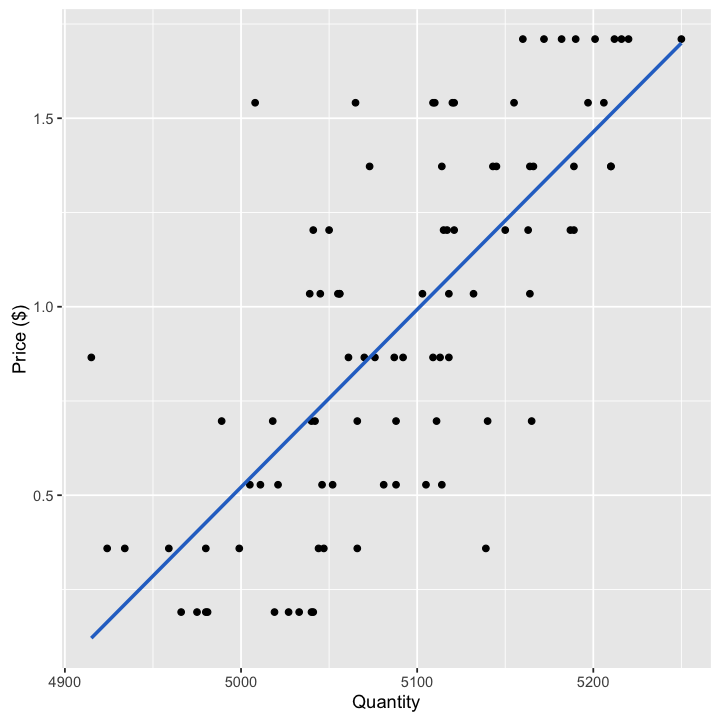

In [560]:
product_changes <- 10
mean_utility <- sort(rep(seq(from = 0.1, to = 0.9, length.out = product_changes), n / product_changes))

prices <- 1.9 * mean_utility

df <- data.frame(day_index = day_index,
                 simulatedErrorProduct = rnorm(n = n)) %>%
    mutate(prices = prices,
           mean_utility = mean_utility,
           utility_product = mean_utility + simulatedErrorProduct + price_coefficient * prices,
           utility_outside = utility_outside,
           purchase_binary = (utility_product > utility_outside)) %>%
    group_by(day_index) %>%
    summarise(quantity = sum(purchase_binary),
              prices = max(prices),
              quality = max(mean_utility))

# upward sloping curve
df %>%
    lm(formula = quantity ~ prices) %>%
    summary()

# cannot separate changes in price from changes in quality
df %>%
    lm(formula = quantity ~ factor(quality) + prices) %>%
    summary()

df %>%
    ggplot(aes(x = quantity, y = prices)) +   
    geom_point(color = "black") +
    geom_smooth(method = lm,   
                se = FALSE, 
                color = '#2A73CC') +
    labs(x = 'Quantity', y = 'Price ($)') 

options(repr.plot.width = 6, repr.plot.height = 6)

### Price Changes *Imperfectly* Co-Timed with Quality Changes


Call:
lm(formula = quantity ~ prices, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-281.52  -90.90    3.87  101.49  233.47 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4263.67      36.75  116.01   <2e-16 ***
prices        478.50      31.32   15.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 121.4 on 88 degrees of freedom
Multiple R-squared:  0.7262,	Adjusted R-squared:  0.7231 
F-statistic: 233.4 on 1 and 88 DF,  p-value: < 2.2e-16



Call:
lm(formula = quantity ~ quality + prices, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-106.631  -35.564   -1.481   39.576  116.586 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5058.79      40.68  124.37   <2e-16 ***
quality      4325.30     205.70   21.03   <2e-16 ***
prices      -2210.38     128.51  -17.20   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 49.52 on 87 degrees of freedom
Multiple R-squared:  0.955,	Adjusted R-squared:  0.9539 
F-statistic: 922.8 on 2 and 87 DF,  p-value: < 2.2e-16


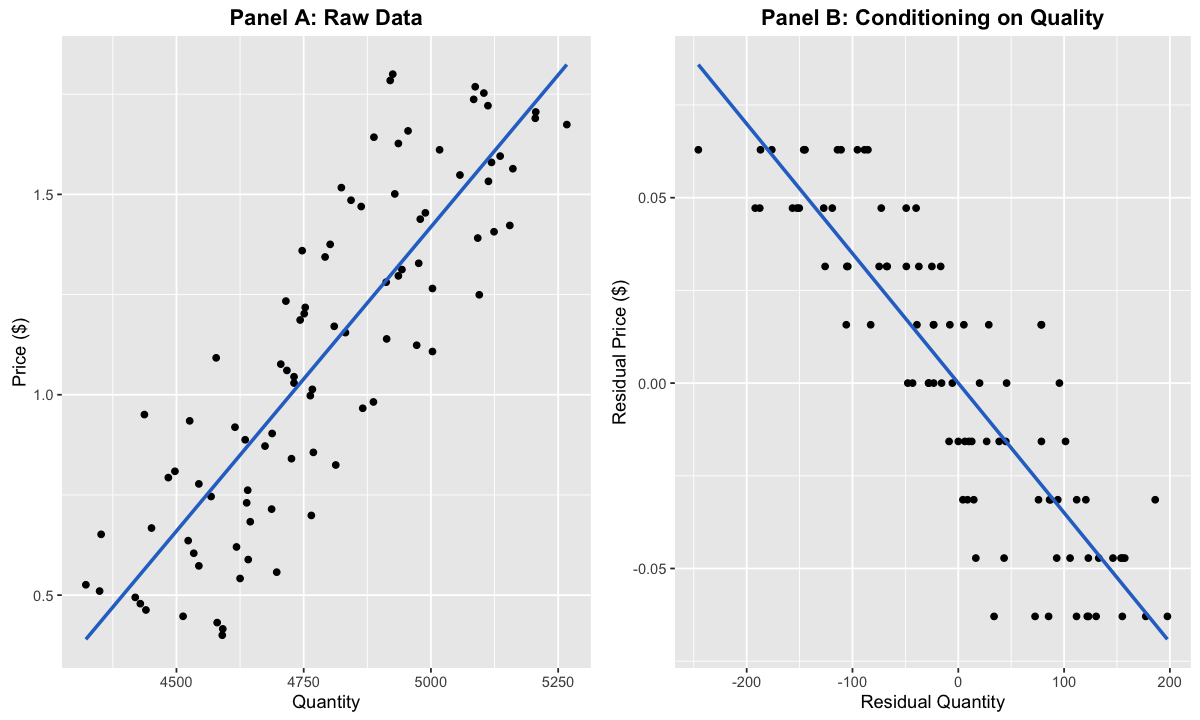

In [568]:
price_changes <- 90
prices <- sort(rep(seq(from = 0.4, to = 1.8, length.out = price_changes), n / price_changes))

df <- data.frame(day_index = day_index,
                 simulatedErrorProduct = rnorm(n = n)) %>%
    mutate(prices = prices,
           mean_utility = mean_utility,
           utility_product = mean_utility + simulatedErrorProduct + price_coefficient * prices,
           utility_outside = utility_outside,
           purchase_binary = (utility_product > utility_outside)) %>%
    group_by(day_index) %>%
    summarise(quantity = sum(purchase_binary),
              prices = max(prices),
              quality = max(mean_utility))

# first show uncontrolled
df %>%
    lm(formula = quantity ~ prices) %>%
    summary()

# can recover price coefficient if control for quality
df %>%
    lm(formula = quantity ~ quality + prices) %>%
    summary()

quantity_fit <- df %>%
    lm(formula = quantity ~ quality)

prices_fit <- df %>%
    lm(formula = prices ~ quality)


basic_plot <- df %>%
    ggplot(aes(x = quantity, y = prices)) +   
    geom_point(color = "black") +
    geom_smooth(method = lm,   
                se = FALSE, 
                color = '#2A73CC') +
    labs(x = 'Quantity', y = 'Price ($)', title = 'Panel A: Raw Data') + 
    theme(plot.title = element_text(face = "bold"))


resid_plot <- df %>%
    ggplot(aes(x = quantity_fit$residuals, y = prices_fit$residuals)) +   
    geom_point(color = "black") +
    geom_smooth(method = lm,   
                se = FALSE, 
                color = '#2A73CC') +
    labs(x = 'Residual Quantity', y = 'Residual Price ($)', title = 'Panel B: Conditioning on Quality') + 
    theme(plot.title = element_text(face = "bold"))

multiplot(basic_plot, resid_plot, cols = 2)

options(repr.plot.width = 10, repr.plot.height = 6)